<a href="https://colab.research.google.com/github/mkvkanpur/Colab/blob/main/misc/shell_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameters

In [ ]:
%%writefile para.py

import numpy as np
import os
import shutil

N = 30

tinit = 0
tfinal = 2
dt = 0.00001
dtby2 = dt/2
integ_method = "RK4"

save_global_interval = 0.1
save_Uk_start = 0 #tfinal/2
save_Uk_interval = 0.1

viscosity = 1e-6

epsilon = 1.0

forcing_shell_from = 2
forcing_shell_to = 3

s = (np.sqrt(5)+1)/2

a1 = s; a2 = -1.0/s; a3 = -1.0

k = np.zeros(N+4)
k[2:N+2] = (s**np.linspace(0,N-1,N))

kexp = np.exp(-viscosity*(k**2)*dt)
kexpby2 = np.exp(-viscosity*(k**2)*dt/2.0)
#print(kexp, kexpby2)
# test

Overwriting para.py


In [ ]:
!python para.py

# field.py

In [ ]:
%%writefile field.py

import numpy as np
from para import *

class Field:
    """ A class representing a bank customer. """
    def __init__(self):
        self.V = []
    #    self.U_Past = []
    #    self.U_Present = []
        self.nlin = []
        self.force = []
        self.temp = []
        self.rhs = []
        self.Euk = []
        self.Tuk = []
        self.flux = []

        # temp array in real space

    def set_initcond(self, V=[]):
        self.V = V
    #    self.U_Past = V
    #    self.U_Present = V
        return

    def set_arrays(self):
        self.force = np.zeros(N+4, dtype=complex)
        self.nlin = np.zeros(N+4, dtype=complex)
        self.temp = np.zeros(N+4, dtype=complex)
        self.rhs = np.zeros(N+4, dtype=complex)
        self.Ek = np.zeros(N, dtype=float)
        self.Tk = np.zeros(N, dtype=float)
        self.flux = np.zeros(N, dtype=float)
        return

    def compute_Euk(self):
    #    self.Ek =  ((np.abs(self.V[2:N+2]))**2)/2
        self.Tk =  np.real(np.conj(self.V[2:N+2]) * self.nlin[2:N+2])
     #   self.Tk =  np.real(np.conj(self.V)  * self.nlin)
        return

    def compute_flux(self):
        self.flux = a3*k[1:N+1]*np.imag(np.conj(self.V[1:N+1]*self.V[2:N+2])*self.V[3:N+3]) \
        -a1*k[2:N+2]*np.imag(np.conj(self.V[2:N+2]*self.V[3:N+3])*self.V[4:N+4])
        return



Writing field.py


In [ ]:
!python field.py

# fns.py


In [ ]:
%%writefile fns.py

import numpy as np
import para
from field import Field
import cmath
import copy

N = para.N
k = para.k

def compute_force_hydro(U = Field()):
    U.force = 0
    return

'''
def compute_force_hydro(U = Field()):
    force_phi1 = 2*np.pi*np.random.random()
    force_phi2 = 2*np.pi*np.random.random()
    omega = cmath.phase(U.V[2])
    if (U.V[2].imag < 0):
        omega = 2*np.pi + omega
    if(abs(np.cos(force_phi1-omega) < 0.1)):
            force_phi1 = np.pi + omega
    U.force[2]=(para.s*para.epsilon/((para.s+1)*abs(U.V[2])*np.cos(force_phi1-omega)))*np.exp(1j*force_phi1)

    omega = cmath.phase(U.V[3])
    if (U.V[3].imag < 0):
            omega = 2*np.pi + omega
    if(abs(np.cos(force_phi2-omega) < 0.1)):
        force_phi2 = np.pi + omega
    U.force[3]=(para.epsilon/((para.s+1)*abs(U.V[3])*np.cos(force_phi2-omega)))*np.exp(1j*force_phi2)

    return
'''
def compute_nlin_hydro(U = Field()):
    U.V[0:2] = 0
    U.V[N+2:N+4] = 0

    U.nlin[0:N+4] = 0

    U.nlin[2:N+2] = para.a1*k[2:N+2]*np.conj(U.V[3:N+3])*U.V[4:N+4] \
        + para.a2*k[1:N+1]*np.conj(U.V[1:N+1])*U.V[3:N+3]  \
        - para.a3*k[0:N]*U.V[1:N+1]*U.V[0:N]

    U.nlin = (-1j*U.nlin)

    return


def  Compute_rhs(U = Field()):
    compute_force_hydro(U)
    compute_nlin_hydro(U)
    U.rhs = U.nlin +U.force

def time_advance_hydro_Euler(U = Field()):
    compute_nlin_hydro(U)
    U.V = (U.V + para.dt * U.nlin)*para.kexp
    return

def time_advance_hydro_RK2(U =  Field()):
    U.temp = copy.deepcopy(U.V)
    Compute_rhs(U)

    # mid
    U.V = (U.temp+para.dtby2*U.rhs)*para.kexpby2
    Compute_rhs(U)

    U.V = U.temp*para.kexp + para.dt*U.rhs*para.kexpby2
    return

def time_advance_hydro_RK4_visc_0(U =  Field()):
    U.temp = (U.V)
    compute_nlin_hydro(U)
    k1 = U.nlin/6

    # mid
    U.V = (U.temp+para.dtby2*U.nlin)
    compute_nlin_hydro(U)
    k1 = k1 + U.nlin/3

    U.V = U.temp+para.dtby2*U.nlin
    compute_nlin_hydro(U)
    k1 = k1 + U.nlin/3

    U.V = U.temp+para.dt*U.nlin
    compute_nlin_hydro(U)
    k1 = k1 + U.nlin/6

    U.V = U.temp + para.dt*k1
    return


def time_advance_hydro_RK4(U =  Field()):
    U.temp = U.V
    Compute_rhs(U)
    k_tot = U.rhs*para.kexp/6

    # mid1
    U.V = (U.temp+para.dtby2*U.rhs)*para.kexpby2
    Compute_rhs(U)
    k_tot  = k_tot + U.rhs*para.kexpby2/3

    # mid2
    U.V = U.temp*para.kexpby2 + para.dtby2*U.rhs
    Compute_rhs(U)
    k_tot  = k_tot + U.rhs*para.kexpby2/3

    U.V = U.temp*para.kexp + para.dt*U.rhs*para.kexpby2
    Compute_rhs(U)
    k_tot  = k_tot + U.rhs/6

    U.V = U.temp*para.kexp + para.dt * k_tot
    return



'''
def compute_nlin_hydro_leapfrog(U = Field()):
    U.U_Present[0:2] = 0
    U.U_Present[N+2:N+4] = 0

    U.nlin[0:N+4] = 0
    U.nlin[2:N+2] = para.a1*k[2:N+2]*np.conj(U.U_Present[3:N+3])*U.U_Present[4:N+4]  + para.a2*k[1:N+1]*np.conj(U.U_Present[1:N+1])*U.U_Present[3:N+3]  - para.a3*k[0:N]*U.U_Present[1:N+1]*U.U_Present[0:N]
    U.nlin = (-1j*U.nlin)
    return

def time_advance_hydro_Leapfrog(U = Field()):
    t = para.tinit
    compute_force_hydro(U)
    compute_nlin_hydro(U)
    # set U.nlin = U.nlin + Force
    U.nlin +=  U.force
    #time_step using Euler
    U.U_Present = (U.U_Past + para.dt * U.nlin)*np.exp(-para.viscosity*(k**2)*para.dt)

    p = 2
    while (p <= para.Nt):
        compute_force_hydro_leapfrog(U)
        compute_nlin_hydro_leapfrog(U)
        U.nlin +=  U.force
        U.V = (U.U_Past)*np.exp(-para.viscosity*(k**2)*2*para.dt) + (2*para.dt * U.nlin)*np.exp(-para.viscosity*(k**2)*para.dt)
        U.U_Past = U.U_Present
        U.U_Present = U.V

        if((p%para.Ns) == 0.0):
            energy = sum(abs(U.V)**2)/2.0
            dissipation = 2.0*para.viscosity*sum((k**2)*abs(U.V)**2)/2.0
            print ("time = {0:.4f}  ".format(t), "Kinetic energy =  {0:.6f}   ".format(energy),"dissipation =  {0:.6f}".format(dissipation))
            U.compute_Euk()
            U.compute_flux()
            write_global_hydro(t, energy, dissipation, para.glob_file)
            write_flux_hydro(U.flux,para.N,t,para.flux_file)
            write_spectrum_hydro(U.Ek,para.N,t,para.spectrum_file)

        t += para.dt
        p +=1
	#return

        # save ukx to a file


def time_advance_BDF_Euler(U = Field(), T=Field()):
    t = para.tinit
    while (t <= para.tfinal):
        force_phi1 = 2*np.pi*np.random.random()
        force_phi2 = 2*np.pi*np.random.random()
        compute_force_hydro(U,force_phi1,force_phi2)
        compute_force_density(T)

        compute_nlin_hydro(U)
        compute_nlin_density(T)
        # set U.nlin = U.nlin - Force
        U.nlin -=  U.force
        T.nlin -= T.force

        #time_step using Euler
        U.V += para.dt * U.nlin
        T.V += para.dt * T.nlin

        t += para.dt

    return

        # save ukx to a file
'''


Writing fns.py


In [ ]:
!python fns.py

# script.py

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/Colab\ Notebooks/data/data_Uk.npy 'data_Uk.npy'

Mounted at /content/gdrive


In [ ]:
import numpy as np
import para
import time
from  field import Field
from fns import *

Vk = np.zeros(N+4, dtype=complex)

L = 2*np.pi/k[2]
def Pope_Model(dissipation_coefficient,epsilon,k):
	p0=2;
	cL=6.78;
	ceta=0.40;
	beta=5.2;
	Kolmogorov_constant=1.5;
	eta=0.42*(dissipation_coefficient**3/epsilon)**0.25;
	ek=np.zeros(N+4)
	for i in range(2,N+2):
		fL_arg=k[i]*L/np.sqrt((k[i]*L/2)**2+cL**2)
		fL=fL_arg**(5./3+p0)
		feta_arg=((k[i]*eta)**4+ceta**4)**0.25-ceta
		feta=np.exp(-beta*feta_arg)
		ek[i]=Kolmogorov_constant*epsilon**(2./3)*k[i]**(-5./3)*fL*feta
	ek[2:-2]=(ek[2:-2])/sum(ek[2:-2]*k[2:-2])
	return epsilon*ek

# Initial condition
#A = Pope_Model(para.viscosity,para.epsilon,para.k)
#Vk[2:N+2] = np.sqrt(k[2:N+2]*A[2:N+2])*np.exp(1j*2*np.pi*np.random.rand(N))

Vk[2:N+2] = np.load('data_Uk.npy')
Vk[2:N+2] = -Vk[2:N+2]

U = Field()
U.set_initcond(Vk)
U.set_arrays()


print ("total initial energy")
print ("time = {0:.4f}   ".format(0), "kinetic enrgy = {0:.6f} \
  ".format(sum(abs(U.V)**2)/2.0),"dissipation =    {0:.6f}   \
  ".format(2.0*para.viscosity*sum((k**2)*abs(U.V)**2)/2.0))

#print ("\nsimulation starts ...")

t = para.tinit
save_global_next = t

energy = np.sum(abs(U.V)**2)/2.0
diss = para.viscosity*np.sum((k**2)*abs(U.V)**2)
print("time = {0:.4f}  ".format(t), " ", energy, " ", diss)

# Arrays for saving data
t_global_array = [t]
energy_global_array = [energy]
diss_global_array = [diss]

t_Uk_Tk_save = [t]
Uk_all = []
Tk_all = []
save_Uk_next = para.save_Uk_start

#Tk_all = U.Tk
#iter = 0
while (True):
	t += para.dt
	if (para.integ_method == "EULER"):
		time_advance_hydro_Euler(U)
	elif (para.integ_method == "RK2"):
		time_advance_hydro_RK2(U)
	elif (para.integ_method == "RK4"):
		time_advance_hydro_RK4(U)

	if (t >= save_global_next):
		energy = np.sum(abs(U.V)**2)/2.0
		diss = para.viscosity*np.sum((k**2)*abs(U.V)**2)
		t_global_array.append(t);
		energy_global_array.append(energy)
		diss_global_array.append(diss)
		save_global_next +=  para.save_global_interval

	if (t >= save_Uk_next):
		U.compute_Euk()
		t_Uk_Tk_save.append(t)
		Uk_all.append(U.V[2:N+2])
		Tk_all.append(U.Tk)
		#iter += 1
		#Tk_all = Tk_all + U.Tk
		save_Uk_next +=  para.save_Uk_interval

	if (t > para.tfinal):
		break;

#Tk_all = Tk_all/iter



total initial energy
time = 0.0000    kinetic enrgy = 2.402254    dissipation =    0.407790     
time = 0.0000     2.402254183336296   0.40779019354204843


In [ ]:
print(np.size(U.V[2:N+2]))

30


# Plot

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (4.5,3.0))
ax.plot(t_global_array,diss_global_array)
ax.set_ylim([0,5]);
print(np.mean(diss_global_array[0:-1]))

0.37041103639088613


(array([13.,  2.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  2.]),
 array([0.00561317, 0.19178686, 0.37796054, 0.56413422, 0.75030791,
        0.93648159, 1.12265527, 1.30882896, 1.49500264, 1.68117632,
        1.86735001]),
 <BarContainer object of 10 artists>)

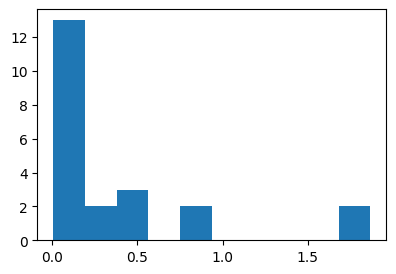

In [ ]:
fig, ax = plt.subplots(figsize = (4.5,3.0))
nbins = 10
ax.hist(diss_global_array, bins=nbins)

In [ ]:
print(np.size(t_Uk_Tk_save))

22


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from google.colab import files
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXGeneral'

mpl.rc('font', size=20)
mpl.rc('axes', titlesize=16) #fontsize of the title
mpl.rc('axes', labelsize=16) #fontsize of the x and y labels
mpl.rc('xtick', labelsize=12) #fontsize of the x tick labels
mpl.rc('ytick', labelsize=12) #fontsize of the y tick labels
mpl.rc('legend', fontsize=20) #fontsize of the legend

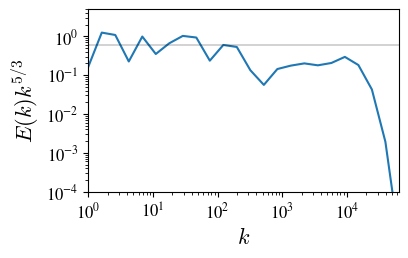

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

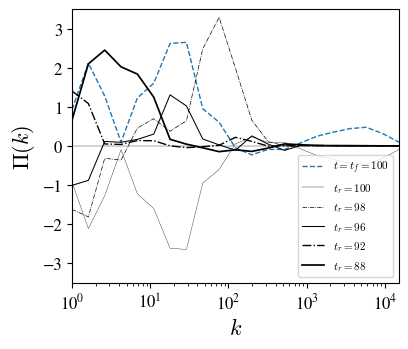

In [ ]:
import para

fig, ax = plt.subplots(figsize = (4.5,3.0))

N = para.N
k = para.k
kp = k[2:N+2]

Uk = Uk_all[0]
ek = ((np.abs(Uk))**2)*kp**(2/3)/2
ax.set_xlim([1,kp[-7]]);
ax.set_ylim([1e-4,5]);
ax.loglog(kp,ek)
ax.axhline(0.6, color='k', lw=0.25)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$E(k)k^{5/3}$')
#ax.set_aspect(aspect=0.7)
plt.tight_layout(pad=1.1)

#plt.savefig("ek_k.pdf")

#files.download("ek_k.pdf")

plt.show()

#####
flux_direct = np.zeros(N)
flux_direct[1:N-2] = 2*np.imag(para.a3*kp[0:N-3]*np.conj(Uk[0:N-3]*Uk[1:N-2])*Uk[2:N-1] \
        -para.a1*k[1:N-2]*np.conj(Uk[1:N-2]*Uk[2:N-1])*Uk[3:N])

fig, ax = plt.subplots(figsize=(4.5,4.0), nrows=1, ncols=1);

kp = k[2:N+2]
Tk = Tk_all[0]
flux_k = np.cumsum(Tk)
ax.set_xlim([1,kp[-10]]);
ax.set_ylim([-3.5,3.5]);
ax.semilogx(kp,flux_k,'--',lw=1,label="$t=t_f = 100$")
ax.axhline(0, color='k', lw=0.25)

Tk = Tk_all[0]; flux_k = -np.cumsum(Tk)
ax.semilogx(kp,flux_k,'k-',lw=0.25,label="$t_r = 100$")

Tk = Tk_all[2]; flux_k = -np.cumsum(Tk)
ax.semilogx(kp,flux_k,'k-.',lw=0.50,label="$t_r=98$")

Tk = Tk_all[4]; flux_k = -np.cumsum(Tk)
ax.semilogx(kp,flux_k,'k-',lw=0.75,label="$t_r= 96$")

Tk = Tk_all[8]; flux_k = -np.cumsum(Tk)
ax.semilogx(kp,flux_k,'k-.',lw=1,label="$t_r=92$")

Tk = Tk_all[12]; flux_k = -np.cumsum(Tk)
ax.semilogx(kp,flux_k,'k-',lw=1.25, label="$t_r =88$")
ax.set_aspect(aspect=0.5)
plt.legend(loc=4, prop = { "size":8 })
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\Pi(k)$')


plt.savefig("pi_k.pdf")
plt.tight_layout(pad=1.1)
files.download("pi_k.pdf")

plt.show()



30 30


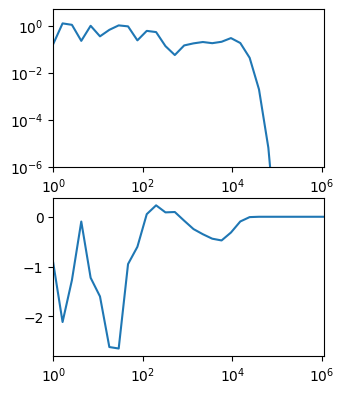

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,4.5), nrows=2, ncols=1);

N = para.N
kp = k[2:N+2]

Uk = Uk_all[0]
ek = ((np.abs(Uk))**2)*kp**(2/3)/2

ax[0].set_xlim([1,kp[-1]]);
ax[0].set_ylim([1e-6,5]);
ax[0].loglog(kp,ek)
#ek_fit = ek[0]*kp**(-2/3)
#ax[0].loglog(kp,ek_fit)

flux_direct = np.zeros(N)
flux_direct[1:N-2] = 2*np.imag(para.a3*kp[0:N-3]*np.conj(Uk[0:N-3]*Uk[1:N-2])*Uk[2:N-1] \
        -para.a1*k[1:N-2]*np.conj(Uk[1:N-2]*Uk[2:N-1])*Uk[3:N])


Tk = Tk_all[0]

flux_k = -np.cumsum(Tk)


#Tk = Tk_all[-2]
kp = k[2:N+2]
ax[1].set_xlim([1,kp[-1]]);
#ax[1].set_ylim([0,1.5]);
#ax[0].set_ylim([1e-6,1]);
#flux_k = -np.cumsum(Tk)
#print(Tk)
print(np.size(flux_k), np.size(kp))
#ax[1].set_xscale('symlog')
#ax[1].set_ylabel('symlogy')
ax[1].semilogx(kp,flux_k)
#ax[1].semilogx(kp,flux_direct)





In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#np.save('data_Uk.npy', Uk_all[-1])

In [ ]:
#!cp -r './data_Uk.npy' /content/gdrive/MyDrive/

In [ ]:
#Uk = np.load('data_Uk.npy')
#print(Uk, Uk_all[-1])

In [ ]:
print(np.shape(Tk_all))
print(list(range(1,41)))

for i in range(41):
    print(np.sum(Tk_all[i]))



(21, 30)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
7.63029917915669e-10
9.371425844931397e-10
3.838696027713695e-11
7.074005828625076e-10
1.0762390978413805e-11
8.401493900578316e-08
3.578347374926075e-10
1.0694734170701482e-10
1.061541992290333e-12
1.5935045268282804e-11
5.5058735348792716e-12
1.7534862450929722e-11
6.852296507986466e-12
4.9713369990486857e-11
6.056932733145004e-12
4.411540123506025e-07
1.1771074451728217e-07
4.959235126411791e-08
1.6699010455776725e-07
3.789214147150514e-08
3.755089651639362e-11


IndexError: list index out of range